<div style="background-color: yellow; padding: 18px;">
    <h1> Data Science Challenge |  Data & Analytics Team
</div>

<div style="background-color: lightblue; padding: 10px;">
    <h2> Case 2 - Similitud entre productos
</div>
    

**Descripción**
 
Un desafío constante en MELI es el de poder agrupar productos similares utilizando algunos atributos de estos como pueden ser el título, la descripción o su imagen.
Para este desafío tenemos un dataset “items_titles.csv” que tiene títulos de 30 mil productos de 3 categorías diferentes de Mercado Libre Brasilultados de ofertas del tipo relampago para un periodo de tiempo y un país determinado.

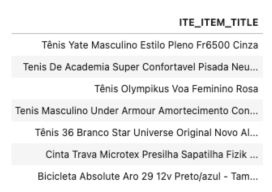

   
El objetivo del desafío es poder generar una Jupyter notebook que determine cuán similares son dos títulos del dataset “item_titles_test.csv” generando como output un listado de la forma donde ordenando por score de similitud podamos encontrar los pares de productos más similares en nuestro dataset de test.
    
___

# Estratégia adotada:

- Pré processamento de textos
- Exploração dos dados
- Embedding com smaller-LaBSE
- Similaridade cosseno
- Apresentação de resultado e conclusão


## Contexto do problema

O título das publicações dos items são escritos pelos sellers e, muitas vezes se referem a produtos idênticos. Entender melhor o produto anunciado ajuda em diversos fluxos como, por exemplo:
- Sugerir um domínio para aquele produto (segmento)
- identificar se o produto é hazmat evitando acidentes nas operações (bateria, aerossol, ácidos entre outros)
- se é permitido o armazenamento em Fulfillments, em qual centro de distribuição devido ao tamanho (bulk, se é totable) e como armazenar (se é de supermercado ou alto valor tem que ficar separado).
- qual tipo de transporte ou manipulação deve ser feita; se pode passar por Meliair
- estimar as dimensões e pesos do item para calcular o frete, dimensionar área do caminhão, selecionar o tipo de caixa caso seja produto de fulfillment.

Enfim, identificar produtos similares pelo título do anúncio é de fundamental importância

### Carregar bibliotecas

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [72]:
import nltk
from unidecode import unidecode
import re
from wordcloud import WordCloud

In [17]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import pandas as pd

In [18]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

### Pré processamento de textos

In [20]:
# Carregando os títulos

titles = pd.read_csv('files/items_titles.csv')

In [21]:
titles.head()

,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Vermelho
1,Tenis Para Caminhada Super Levinho Spider Corrida
2,Tênis Feminino Le Parc Hocks Black/ice Original Envio Já
3,Tênis Olympikus Esportivo Academia Nova Tendência Triunfo
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve


In [22]:
titles.shape

(30000, 1)

Os títulos são de produtos MLB, em português.

- Vamos remover a pontuação permanecendo com letrar e números
- Transformar todas as letras em minúsculas.

In [24]:
# Download necessário para tokenização de palavras utilizando a biblioteca NLTK
nltk.download('punkt')

# Função de pre processamento de texto:
def preprocessing(string):
    string = unidecode(string) # remover acentuação
    string = re.sub(r"[^a-zA-Z0-9]+", ' ', string) #alfa numérico
    string = string.lower() #minúsculas
    words = nltk.tokenize.word_tokenize(string) # tokenização
    return words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RMM\miniconda3\envs\tf\lib\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
# Tokenizar o texto 

titles['ITE_ITEM_TITLE_token'] = titles['ITE_ITEM_TITLE'].apply(lambda x: preprocessing(x))

In [28]:
titles.head()

,ITE_ITEM_TITLE,ITE_ITEM_TITLE_token
0,Tênis Ascension Posh Masculino - Preto E Verme...,"[tenis, ascension, posh, masculino, preto, e, ..."
1,Tenis Para Caminhada Super Levinho Spider Corr...,"[tenis, para, caminhada, super, levinho, spide..."
2,Tênis Feminino Le Parc Hocks Black/ice Origina...,"[tenis, feminino, le, parc, hocks, black, ice,..."
3,Tênis Olympikus Esportivo Academia Nova Tendên...,"[tenis, olympikus, esportivo, academia, nova, ..."
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...,"[inteligente, led, bicicleta, tauda, luz, usb,..."


### Exploração dos dados

Na exploração de textos, passamos por alguns passos:
- Análise de frequência das palavras
    - Contagem das frequências das palavras no conjunto de dados tokenizado.
    - Identificação das palavras mais frequentes e menos frequentes. 
- Visualização de dados
    - Criação de gráficos, como histogramas ou nuvens de palavras, para visualizar as principais características dos dados tokenizados
- Análise de s-gramas
    - Identificação de sequências de palavras consecutivas, conhecidas como n-gramas (bi-gramas, tri-gramas, etc.).
- Remoção de stopwords
    - Identificação e remoção de palavras comuns, mas pouco informativas (para se concentrar nas palavras mais significativas).
- Análise de comprimento de palavra

In [29]:
titles.head()

,ITE_ITEM_TITLE,ITE_ITEM_TITLE_token
0,Tênis Ascension Posh Masculino - Preto E Verme...,"[tenis, ascension, posh, masculino, preto, e, ..."
1,Tenis Para Caminhada Super Levinho Spider Corr...,"[tenis, para, caminhada, super, levinho, spide..."
2,Tênis Feminino Le Parc Hocks Black/ice Origina...,"[tenis, feminino, le, parc, hocks, black, ice,..."
3,Tênis Olympikus Esportivo Academia Nova Tendên...,"[tenis, olympikus, esportivo, academia, nova, ..."
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...,"[inteligente, led, bicicleta, tauda, luz, usb,..."


In [36]:
# Criando uma lista com todas as palavras tokenizadas
all_words = [word for sublist in titles['ITE_ITEM_TITLE_token'] for word in sublist]

# Calculando a frequência das palavras
freq_dist = nltk.FreqDist(all_words)

# Extraindo as palavras mais frequentes
most_common_words = freq_dist.most_common()

# Exibindo as palavras mais frequentes
print("Palavras mais frequentes:")
print(most_common_words[:10])  # Exibindo as 10 mais frequentes

Palavras mais frequentes:
[('tenis', 22600), ('feminino', 7931), ('masculino', 5349), ('casual', 3757), ('preto', 3664), ('infantil', 3496), ('original', 2766), ('sapatenis', 2630), ('bicicleta', 2248), ('de', 1928)]


In [37]:
# Extraindo as palavras menos frequentes
least_common_words = freq_dist.hapaxes()

# Exibindo as palavras menos frequentes
print("\nPalavras menos frequentes:")
print(least_common_words[-100:])


Palavras menos frequentes:
['ranst', 'f35651', 'essesntial', 'kamikaze', 'dlites', '14001', 'calcefacil', 'chess', 'ef04206', '0197ja', 'cc1929', 'ct0450', 'golf', 'ultrapace', '607a', '893', 'universo', '2614', '1785', 'c1846a', 'zm', '428015', 'mroavck', '248', '9403m', '1023', '353', 'cipollini', 'rb1k', 'rb1000', 'maithe', '3008cl', '43398772', '0062', 'l650', '22123', 'db0273', '209128', '23110028', 'iniki', 'xrt', '12020', 'dali', 'l7t5uar66', 'streamer', '0042', 'fero', 'precious', '3900', 'bx2118', '014125', '2801235', 'noiva', '3x1', '1551', 'boxxer', '323006000', '2529101', 'femininno', '0960147', 'casualtenis', 'silverwhite', 'rav', 'respirabilidade', '0849', 'canin', '2133650', 'bx1731', 'vv1054', 'ocul', '012867', 'fechada', 'chm', 'construction', '12004', 'ad1803', '0417', '15902', '1334', '1802', 'nautec', '0236', '2436', '111886', 'a2402', 'billie', 'eilish', 'ondas', 'newrln', 'vi', 'b677', '72202', 'sucata', '10440', 'quik', 'pharrel', 'solarhu', 'hajime', 'javelin',

Como, entre as 10 mais frequentes, está a palavra _de_ e ela traz pouca informação, podemos considerá-la como stopword 

In [44]:
# nltk.download('stopwords')

# Carrega a lista de stopwords em português
stop_words = set(nltk.corpus.stopwords.words('portuguese'))

In [49]:
# Essas são as stopwords do corpus de nltk em português
list(stop_words)[:20]

['foi',
 'tivéssemos',
 'este',
 'for',
 'seja',
 'tive',
 'há',
 'houverão',
 'mais',
 'quando',
 'ao',
 'aquele',
 'como',
 'só',
 'tivera',
 'terá',
 'tiveram',
 'tivéramos',
 'nem',
 'tivessem']

In [57]:
# Checar a existência de algumas palavras dentro da lista de stopwords
for palavra in ['sem', 'não', 'nao']:
    print(palavra, palavra in stop_words)

sem True
não True
nao False


In [54]:
# Removendo stop words do títulos
titles['ITE_ITEM_TITLE_token_stopwords'] = titles['ITE_ITEM_TITLE_token'].apply(lambda tokens: [token for token in tokens if token.lower() not in stop_words])

In [56]:
titles.head()

,ITE_ITEM_TITLE,ITE_ITEM_TITLE_token,ITE_ITEM_TITLE_token_stopwords
0,Tênis Ascension Posh Masculino - Preto E Verme...,"[tenis, ascension, posh, masculino, preto, e, ...","[tenis, ascension, posh, masculino, preto, ver..."
1,Tenis Para Caminhada Super Levinho Spider Corr...,"[tenis, para, caminhada, super, levinho, spide...","[tenis, caminhada, super, levinho, spider, cor..."
2,Tênis Feminino Le Parc Hocks Black/ice Origina...,"[tenis, feminino, le, parc, hocks, black, ice,...","[tenis, feminino, le, parc, hocks, black, ice,..."
3,Tênis Olympikus Esportivo Academia Nova Tendên...,"[tenis, olympikus, esportivo, academia, nova, ...","[tenis, olympikus, esportivo, academia, nova, ..."
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...,"[inteligente, led, bicicleta, tauda, luz, usb,...","[inteligente, led, bicicleta, tauda, luz, usb,..."


A coluna ITE_ITEM_TITLE_token_stopwords possui o texto tokenizado sem as stopwords importadas do nltk. Porém não vou usar pois palavras como "sem" e "não" estão dentro desse conjunto e acredito que seja importante usar. Exemplo: "...sem bateria.." é diferente de bateria inclusa. Eu poderia remover manualmente mas não é o propósito nesse momento. Além disso, precisaria retirar a acentuação dessas stopwords

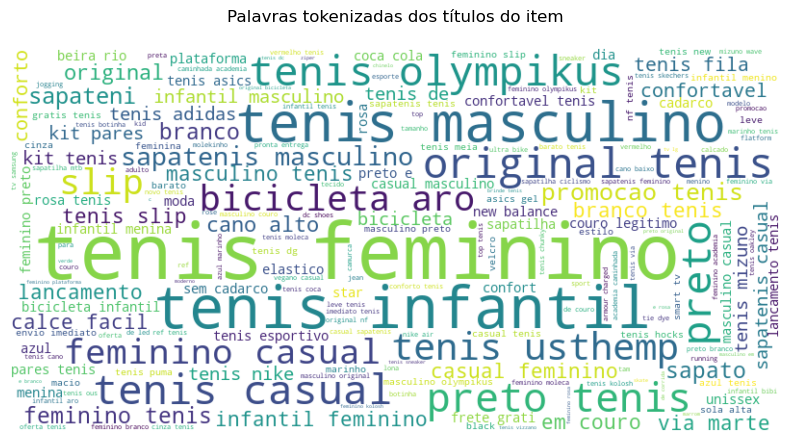

In [65]:
# Visualização dos títulos tokenizados com o wordcloud

# Criar uma lista com todas as palavras tokenizadas
all_words = [word for sublist in titles['ITE_ITEM_TITLE_token'] for word in sublist]

# Unir as palavras em uma única string
text = ' '.join(all_words)

# Criar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Exibir a nuvem de palavras usando Matplotlib
plt.figure(figsize=(12, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Palavras tokenizadas dos títulos do item\n')
plt.axis('off')
plt.show()

As palavras `tenis`, `feminino`, `casual` aparecerem frequentemente, o que era esperado pois estava nas 10 palavras mais frequentes

#### Embedding

Poderíamos usar o TF-IDF (que atribui um peso levando em consideração a frequência e a raridade) mas métodos de word embedding são mais robustos e eficientes.

O word embedding é uma técnica que representa palavras como vetores contínuos em um espaço de alta dimensão. Esses vetores são criados de tal forma que palavras semelhantes em significado têm representações numéricas próximas umas das outras no espaço vetorial.

Existem várias técnicas para criar word embeddings como Word2Vec, GloVe e FastText. Inclusive, o modelo de similaridade que a equipe de PyMes (pesos e medidas) do Meli usa, é um FastText junto com um KNN Annoy para estimar as dimensões do item. Usamos o título e o preço para o word embedding e criamos o modelo português e o modelo espanhol (com padronização do preço em dólar)

Vou usar um modelo de wmbedding de sentenças desenvolvido pela Google Research que se baseia na arquitetura BERT (Bidirectional Encoder Representations from Transformers) para gerar representações vetoriais de sentenças.

Pelo fato do LaBSE ter a capacidade de gerar embeddings de sentenças que são independentes do idioma, seria uma solução para os títulos dos items do Meli cross site. Poderíamos treinar o modelo em pares de sentenças paralelas em português e espanhol, permitindo que o modelo aprenda representações universais para sentenças independentemente do idioma específico. Obs.: Na equipe de PyMes continuamos melhorando os modelos baseados em FastText+KNN annoy. Ainda não sugeri, analisei a viabilidade e nem testei o uso de outros modelos de word embedding.

**smaller-LaBSE**

"The smaller LaBSE(language-agnostic BERT sentence embedding) is a patched version of google/LaBSE/2 to handle fewer languages by applying "Load What You Need: Smaller Versions of Multilingual BERT". To summarize the contents of the paper, only selected tokens that appear frequently in the corpus(Wikipedia dump for this model) are left in the word embedding table."

O código pode ser acessado por esse repositório [aqui](https://github.com/jeongukjae/smaller-labse)

In [19]:
# Gera embedding e aplica normalização L2

# Carrega o modelo a partir de tfhub.dev
encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang/1")
preprocessor = hub.KerasLayer("https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang_preprocess/1")

# Construindo o modelo para codificar textos em vetores de alta dimensão
sentences = tf.keras.layers.Input(shape=(), dtype=tf.string, name="sentences")
encoder_inputs = preprocessor(sentences)

# Obtém a representação da sentença a partir do encoder
sentence_representation = encoder(encoder_inputs)["pooled_output"]

# Aplica normalização L2 para similaridade de cosseno
normalized_sentence_representation = tf.nn.l2_normalize(sentence_representation, axis=-1)

# Criação do modelo usando TensorFlow Keras
model = tf.keras.Model(sentences, normalized_sentence_representation)

# Exibe um resumo do modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentences (InputLayer)         [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_type_ids':   0           ['sentences[0][0]']              
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

- Processando os dados dos títulos (ITE_ITEM_TITLE)

In [23]:
# usando os dados dos títulos (original)
titles.head()

,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Vermelho
1,Tenis Para Caminhada Super Levinho Spider Corrida
2,Tênis Feminino Le Parc Hocks Black/ice Original Envio Já
3,Tênis Olympikus Esportivo Academia Nova Tendência Triunfo
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve


In [24]:
# Pega os dados dos títulos
product_data = titles['ITE_ITEM_TITLE'].values

In [25]:
# Gera embeddings para os dados dos títulos
product_embedding_data = model.predict(product_data)

938/938 [==============================] - 6771s 7s/step


In [26]:
# Cria um DataFrame 
product_embedding_data_df = pd.DataFrame(product_embedding_data)

In [27]:
# Adiciona a coluna 'ITE_ITEM_TITLE' ao DataFrame original 
product_embedding_data_df['ITE_ITEM_TITLE'] = titles['ITE_ITEM_TITLE']

In [28]:
# Salva os embeddings e os títulos em um arquivo CSV
product_embedding_data_df.to_csv('output/items_titles_embedding.csv', index=False)

In [ ]:
# Carrega arquivo (backup)
product_embedding_data_df = pd.read_csv('output/items_titles_embedding.csv') # output/items_titles_embedding.csv
product_embedding_data_df.shape

- Processando os dados dos títulos do arquivo de test 

In [100]:
titles_test = pd.read_csv('files/items_titles_test.csv')

In [101]:
product_test_data = titles_test['ITE_ITEM_TITLE'].values

In [34]:
# Gera embeddings para os títulos de teste 
product_test_embedding_data = model.predict(product_test_data)

313/313 [==============================] - 2295s 7s/step


In [102]:
product_test_embedding_data_df = pd.DataFrame(product_test_embedding_data)

In [103]:
product_test_embedding_data_df['ITE_ITEM_TITLE'] = titles_test['ITE_ITEM_TITLE']

In [104]:
# Salva o dataframe (fazer backup para não ter que rodar de novo)
product_test_embedding_data_df.to_csv('output/items_titles_test_embedding.csv', index=False)

In [ ]:
# Carrega dataframe (caso queira recuperar os dados)
product_test_embedding_data_df = pd.read_csv('output/items_titles_test_embedding.csv')
product_test_embedding_data_df.shape

- Função de similaridade de cosseno do scikit-learn

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

In [39]:
# Excluindo os títulos originais
product_embedding = product_embedding_data_df.loc[:, product_embedding_data_df.columns != 'ITE_ITEM_TITLE']

In [40]:
# Excluindo os títulos originais de teste
product_test_embedding = product_test_embedding_data_df.loc[:, product_test_embedding_data_df.columns != 'ITE_ITEM_TITLE']

In [41]:
# Calcula a similaridade de cosseno entre os embeddings de produtos de teste e produtos
product_similarity = cosine_similarity(product_test_embedding, product_embedding)

In [105]:
print(product_similarity.shape) 

(10000, 30000)


10.000 produtos de teste comparados com 30.000 produtos

In [106]:
products = product_embedding_data_df['ITE_ITEM_TITLE']
product_test = product_test_embedding_data_df['ITE_ITEM_TITLE']

In [107]:
# Todas as combinações possíveis
product_pairs = pd.DataFrame(index=pd.MultiIndex.from_product([product_test, products], names=['ITE_ITEM_TITLE_A', 'ITE_ITEM_TITLE_B']))

In [108]:
# Criar a coluna de similaridade : SCORE SIMILITUD
product_pairs['SCORE SIMILITUD'] = product_similarity.flatten()

In [109]:
# Formato dos dados
product_pairs

SCORE SIMILITUD
ITE_ITEM_TITLE_A                                           ITE_ITEM_TITLE_B                                                             
Tênis Olympikus Esporte Valente - Masculino Kids           Tênis Ascension Posh Masculino - Preto E Vermelho                  0.50817961
                                                           Tenis Para Caminhada Super Levinho Spider Corrida                  0.40402037
                                                           Tênis Feminino Le Parc Hocks Black/ice Original Envio Já           0.37843829
                                                           Tênis Olympikus Esportivo Academia Nova Tendência Triunfo          0.65288967
                                                           Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve        0.24884292
...                                                                                                                                  ...
Tênis Polo Ralph Lauren Modelo Cantor Low Branco Masculino Tênis Vans Old Skool I Love My Vans - Usado - Feminino             0.36602473
                                                           Tênis Feminino Preto Moleca 5296155                                0.32768860
                                                           Tenis Botinha Com Pelo Via Marte Original Lançamento               0.26112252
                                                           Tênis Slip On Feminino Masculino Original Sapato Xadrez Mule       0.44079465
                                                           Bicicleta Nathor Rosa Infantil Sem Pedal Balance Aro 12            0.33910701

[300000000 rows x 1 columns]

In [110]:
# Uma amostra dos dados
product_pairs.sample(10)

,,SCORE SIMILITUD
ITE_ITEM_TITLE_A,ITE_ITEM_TITLE_B,
Tênis Slip On Feminino Azul C/cadarço E Detalhes Dourados,Tenis Para Corrida Feminino Confortavel Academia Casual,0.40802306
Tênis Casual Feminino Sola Alta Via Marte 18-17702 Apé,Kit 3 Pares Sapatenis Masculino Varias Cores Frete Grátis!,0.28820455
Tenis All Star Chuck Taylor Lilas Prata - Serie Limitada,Sapatilha Mtb Mattos Racing New Ttr 20 Preta E Fluor Catraca,0.30557919
Tênis Feminino Casual Vizzano Slip On Flatform,Tv Samsung Qled 8k Q800t Semi Nova,0.01409073
Asics Lyte,Tenis Feminino Branco E Rosa Casual,0.07653652
Tênis Activtta Corrida Masculino Esportivo Cataluna,Tênis Infantil Pampili Cano Médio Now United Branco/velcro,0.40892044
Bicicleta Gti Roma 29,Tênis Vibe Roots Dead Fish - Masculino,0.18593091
Tênis Meia Feminino Slip-0n Cinza Stone Santa Lolla Original,Tênis Chunky Infantil Molekinho Nylon Preto/cinza,0.39182061
Bicicleta Sense Invictus Evo 21/22 Aro 29,Tênis Feminino Fila Fit Trainer 2.0,0.26605347


In [111]:
# Combinações possíveis
product_pairs.shape

(300000000, 1)

In [113]:
# Salvando para poder carregar depois
product_pairs.to_csv('output/items_titles_similarity_index.csv')

In [116]:
# Transformar em coluna produto_a e produto_b
pairwise_df = product_pairs.reset_index()

In [115]:
pairwise_df.shape

(300000000, 3)

In [78]:
pairwise_df.head(30)

,ITE_ITEM_TITLE_A,ITE_ITEM_TITLE_B,SCORE SIMILITUD
0,Tênis Olympikus Esporte Valente - Masculino Kids,Tênis Ascension Posh Masculino - Preto E Vermelho,0.508180
1,Tênis Olympikus Esporte Valente - Masculino Kids,Tenis Para Caminhada Super Levinho Spider Corrida,0.404020
2,Tênis Olympikus Esporte Valente - Masculino Kids,Tênis Feminino Le Parc Hocks Black/ice Original Envio Já,0.378438
3,Tênis Olympikus Esporte Valente - Masculino Kids,Tênis Olympikus Esportivo Academia Nova Tendência Triunfo,0.652890
4,Tênis Olympikus Esporte Valente - Masculino Kids,Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve,0.248843
5,Tênis Olympikus Esporte Valente - Masculino Kids,Tênis Casual Masculino Zarato 941 Preto 632,0.371097
6,Tênis Olympikus Esporte Valente - Masculino Kids,Tênis Infantil Ortopasso Conforto Jogging,0.616424
7,Tênis Olympikus Esporte Valente - Masculino Kids,Tv Samsung Qled 8k Q800t Semi Nova,-0.003005
8,Tênis Olympikus Esporte Valente - Masculino Kids,Tênis Usthemp Short Temático - Maria Vira-lata 2,0.371656
9,Tênis Olympikus Esporte Valente - Masculino Kids,Sapatênis West Coast Urban Couro Masculino,0.518552


In [79]:
pairwise_df.sample(10)

,ITE_ITEM_TITLE_A,ITE_ITEM_TITLE_B,SCORE SIMILITUD
5686129,Tênis Masculino adidas Harden Stepback 2 Fz1384,Tenis Balenciaga Triple-s,0.158437
16117232,Tênis / Bota Vans Numero 38,Polo Wear Sapatenis Bordo/branco 38 85686,0.408357
3648417,Bicicleta Mountain Bike Sense Impact Pro,Tênis Feminino Active Beira Rio,0.347877
6307523,Tênis Skate Dc Shoes Anvil La Amarelo/azul/branco Envio Já,Tênis Corrida Masculino Asics Gel Quantum 180 5,0.454929
29033690,Tenis Masculino Asics Gel Lyte V Pastel Original,Tênis Diana Couro Preto - K. Daher,0.209575
4698282,Tênis Skechers Dlites - Me Time,Tênis Under Armour Spawn 3,0.350996
12965974,Tênis Feminino Mississipi Preto,"Tênis Mvp - Cross, Funcional E Academia - Mvp",0.379356
18681058,Tenis All Star 04/2021 Ct04950001 Preto/bco,Bicicleta Infantil Aro 12 Motor X Pu Bike Vermelho Amarelo,0.235380
14520934,Tênis Wmns Nike Revolution 5 Branco E Rosa Salmão Bq3207 109,Tenis Botinha Casual Feminino Treino Fit Cano Alto Oferta,0.271406
21815360,Tênis Usthemp Folks Vegano Casual Art Love English Bulldog,Tenis Via Marte Nude 21-3163,0.184462


In [74]:
# Salvando os dados
pairwise_df.to_csv('output/items_titles_similarity.csv', index=False)

In [ ]:
# Recuperando os dados
pairwise_df = pd.read_csv('output/items_titles_similarity.csv')

In [80]:
pairwise_sorted_df = pairwise_df.sort_values(by='SCORE SIMILITUD', ascending=False)

In [93]:
# Configurando para aparecer 8 casas decimais
pd.set_option('display.float_format', '{:.8f}'.format)

In [98]:
pairwise_sorted_df[pairwise_sorted_df['SCORE SIMILITUD']<0.98].head(10)

,ITE_ITEM_TITLE_A,ITE_ITEM_TITLE_B,SCORE SIMILITUD
3600956,Bicicleta Aro29 Q21 Susp Trava Fr Hidr Z4-x 24v Preto Dropp,Bicicleta Aro29 Q17 Susp Trava Fr Hidr Z4-x 24v Preto Drop,0.97950970
7037613,Tênis Esportivo Feminino Adrun Soft Gel 9602f-1204 Azul,Tênis Esportivo Feminino Adrun Soft Gel 9601f-1246 Cinza,0.97900160
9126859,Tenis Dg Sorrento G1 Rosa Unissex Ouro,Tenis Dg Sorrento G1 Preto Rosa Unissex Ouro,0.97793317
18308999,Tenis Infantil Tênis Infantil Feminino Brinde Bolsa Não Perc,Tenis Infantil Tênis Infantil Feminino Brinde Bolsa Imperdív,0.97773160
16610625,Dois Pares Tênis Kappa Impact Masculino - Preto E Branco,Dois Pares Tênis Kappa Impact Masculino - Preto E Vermelho,0.97745600
26827590,Tênis Ous Phibo 2134 Preto Branco Oe,Tênis Öus Phibo 2134 Preto E Branco Oe,0.97725886
21055712,Bicicleta Aro 29 Dropp 21v Suspensão Freio Disco Cinza 17,Bicicleta Aro 29 Dropp 21v Suspensão Freio A Disco Rosa 17,0.97685000
10929985,Tênis Infantil Meninas Molekinha,Tênis Molequinha Infantil Menina,0.97684795
5660585,Tênis Feminino Mizuno Wave Prime 9 -lançamento-frete Grátis,Tênis Feminino Mizuno Wave Prime 9 -lançamento,0.97667027
14607860,Tenis Menina Infantil Feminino Escola Limitado,Tenis Infantil Feminino Menina Escolar E Limitado,0.97583420


In [99]:
pairwise_sorted_df.tail(10)

,ITE_ITEM_TITLE_A,ITE_ITEM_TITLE_B,SCORE SIMILITUD
23333173,Tênis Feminino Suzzara,Tv 32p Aoc Led Smart Wifi Hd Hdmi 32s5195,-0.20652530
2326685,Vapor Max Plus,Chinelo Dakota Rasteira Com Pedraria - Z5272 Aa,-0.20674524
8519175,Melissa Gadget Bege,Dunk,-0.20835203
23609976,Tv Multilaser 32 Hd Smart Led Wifi Hdmi C/conversor Tl020,Sapatênis Osklen Original,-0.21167654
24373035,Tv 26 LG 26le5300,Tênis Usthemp Short Temático - Skull Pineapple,-0.21583825
24384941,Tv 26 LG 26le5300,Bota Tênis Professional's Choice Pit Stop Couro Com Cadarço,-0.21887910
24388845,Tv 26 LG 26le5300,Tênis Usthemp Pepper Temático - Skull Pineapple,-0.21975528
23415745,Sapatênis Masculino Freeway Promoção Phanton,Kit Tela Toshiba Smart Qled 55 4k E Pipoqueira 127v Tb001k,-0.22215505
22858350,Tênis Infantil Caminhada Confortavel Feminino Olympikus Saga,Tv 42 Hbuster - Hbtv-42l03fd,-0.22911122
24369496,Tv 26 LG 26le5300,Tênis Usthemp Half Temático - Skull Pineapple,-0.24230722


# Conclusão

Com o desafio de agrupar produtos similares com base em seus títulos, adotamos uma estratégia robusta que envolveu várias etapas de pré-processamento, análise exploratória e técnicas avançadas de processamento de linguagem natural.

Utilizamos o modelo de embedding smaller-LaBSE para transformar os títulos dos produtos em representações vetoriais significativas. A similaridade cosseno foi empregada para calcular a similaridade entre os títulos, gerando uma matriz que reflete as relações entre os produtos.

Acredito que seja uma técnica excelente que foi executada em uma amostra de dados reais e que pode ser implementada. Um caso de uso pode ser a substituição dos modelos de similaridade que é usado pela equipe de PyMes. Hoje usamos um embedding FastText e o KNN annoy para estimar o peso e as medidas dos items (um para MLB e outro para espanhol). O word embedding é usado com o título e o preço do item. 
A vantagem é usar apenas um modelo pois o smaller-LaBSE é projetado para lidar com sentenças em vários idiomas em um mesmo texto.

Obs.: Uma parte do notebook foi executado localmente e outra parte no google colab pro. Não usei ambiente Meli (Fury).    

Foi um desfio para mim pois foi a primeira vez que implementei.

<div style="background-color: lightblue; padding: 10px;">
    <h2> Gracias  <br>
        <h5>Renata Martins Marchese
</div>